# Übung Einstieg Deep Reinforcemente Learning (Hausaufgabe #11)

### Übungssetup

Teammitglieder Gruppe 3
- Hans Wermelinger
- Helmut Gehrer
- Markus Näpflin
- Nils Hryciuk
- Stefano Mavilio


## Gymnasium Cartpole, optimising with Optuna

Environment: [Gymnasium Cartpole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

Optuna Framework: [optuna.org](https://optuna.org/)

### Install / load libraries



In [ ]:
%%capture
%%bash
pip3 install gymnasium[classic_control]
pip3 install optuna
pip install optuna-dashboard

In [ ]:
import gymnasium as gym
import optuna
from optuna.trial import TrialState
import joblib
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Ingredients


### DQ-Network

#### Noisy Layer

In [ ]:
class NoisyLinear(nn.Linear):
    def __init__(self, in_features, out_features, sigma_init=0.017, bias=True):
        super(NoisyLinear, self).__init__(in_features, out_features, bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features, in_features), sigma_init))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,), sigma_init))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        std = math.sqrt(3 / self.in_features)
        self.weight.data.uniform_(-std, std)
        self.bias.data.uniform_(-std, std)

    def forward(self, input):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.data
        return F.linear(input, self.weight + self.sigma_weight * self.epsilon_weight.data, bias)

#### static DQN

As in the exercise template


In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#### Dynamic (optimising) DQN

- Including noisy layer and dueling concept.
- Optimiser determines the depth and size of the network

In [ ]:
# Dynamic DQN
class DDQN(nn.Module):
    def __init__(self, trial, n_observations, n_actions):
        super(DDQN, self).__init__()
        n_layers = trial.suggest_int("n_layers", 1, 3)  # Nur noch 1-3 weil noisy layer noch dazu kommt
        layers = []

        in_features = n_observations
        for i in range(n_layers):
            # out_features = trial.suggest_int(f"n_units_l{i}", 16, 256)
            out_features = trial.suggest_categorical(f"n_units_l{i}", [64, 128, 256, 512])
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            # p = trial.suggest_float(f"dropout_l{i}", 0.2, 0.5)
            # layers.append(nn.Dropout(p))
            in_features = out_features

        # Append Noisy layer
        layers.append(NoisyLinear(in_features, 128, sigma_init=0.3))
        self.model = nn.Sequential(*layers)

        self.fc_adv = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        self.fc_val = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        val = self.fc_val(self.model(x))
        adv = self.fc_adv(self.model(x))
        return val + adv - adv.mean()


### Replay Memory

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Functions

### Select action

In [ ]:
def select_action_eps(state, policy_net, action_space, steps_done, eps_start, eps_end, eps_decay):
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1), steps_done
    else:
        return torch.tensor([[action_space.sample()]], device=device, dtype=torch.long), steps_done

In [ ]:
def select_action(state, policy_net, action_space, steps_done):
    sample = random.random()
    steps_done += 1
    with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
      return policy_net(state).max(1).indices.view(1, 1), steps_done

### optimise model

In [ ]:
def optimize_model(memory, target_net, policy_net, optimizer, gamma, batchsize):
    if len(memory) < batchsize:
        return memory, target_net, policy_net, optimizer
    transitions = memory.sample(batchsize)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batchsize, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    return memory, target_net, policy_net, optimizer


## Objective

In [ ]:
# constants (for all trials)
EPISODES = 500
EPS_START = 0.9
EPS_END = 0.05
TAU = 0.005

def objective(trial):

    # trial features
    gamma = trial.suggest_float("gamma", 0.95, 0.99)
    batchsize = trial.suggest_int("batchsize", 128, 512, step=128)
    memory_size = trial.suggest_int("memory_size", 10000, 100000, step=10000)
#    eps_decay = trial.suggest_int("eps_decay", 1000, 10000, step=1000)

    env = gym.make("CartPole-v1")

    # Get number of actions from gym action space
    n_actions = env.action_space.n
    # Get the number of state observations
    state, info = env.reset()
    n_observations = len(state)

    # Generate the model.
    policy_net = DDQN(trial, n_observations, n_actions).to(device)
    target_net = DDQN(trial, n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    # Generate the model w/o optimisation.
    # policy_net = DQN(n_observations, n_actions).to(device)
    # target_net = DQN(n_observations, n_actions).to(device)
    # target_net.load_state_dict(policy_net.state_dict())

    # Generate the optimizers.
    # optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

    # optuna optimizers
    # optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])
    optimizer_name = "AdamW"
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(policy_net.parameters(), lr=lr)

    # Generate ReplayMemory
    memory = ReplayMemory(memory_size)

    steps_done = 0
    max_reward = 0
    sum_reward = 0


    # Training of the model
    for i_episode in range(EPISODES):
      total_reward = 0  # Track the total reward for this episode
      # Initialize the environment and get its state
      state, info = env.reset()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      for t in count():
          # action, steps_done = select_action_eps(state, policy_net, env.action_space, steps_done, EPS_START, EPS_END, eps_decay)
          action, steps_done = select_action(state, policy_net, env.action_space, steps_done)
          observation, reward, terminated, truncated, _ = env.step(action.item())
          reward = torch.tensor([reward], device=device)
          total_reward += reward.item()  # Accumulate rewards

          # Debugging: Print step and reward information
          # print(f"Episode {i_episode}, Step {t}, Reward: {reward.item()}, Total Reward: {total_reward}")

          done = terminated or truncated

          if terminated:
             next_state = None
          else:
              next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

          # Store the transition in memory
          memory.push(state, action, next_state, reward)

          # Move to the next state
          state = next_state

          # Perform one step of the optimization (on the policy network)
          memory, target_net, policy_net, optimizer = optimize_model(memory, target_net, policy_net, optimizer, gamma, batchsize)

          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′
          target_net_state_dict = target_net.state_dict()
          policy_net_state_dict = policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
          target_net.load_state_dict(target_net_state_dict)

          if done:
            # print(f"Trial {trial.number}, Episode {i_episode}, Total Reward: {total_reward}, nach {t} Schritten")
            break

      # Debugging: Print total reward at the end of each episode
      # print(f"Trial {trial.number}, end of Episode {i_episode}, Total Reward: {total_reward}")

      trial.report(total_reward, i_episode)

      if total_reward > max_reward:
        max_reward = total_reward
      sum_reward += total_reward * total_reward

      # Handle pruning
      if trial.should_prune():
        raise optuna.TrialPruned()

    return sum_reward


# Prepare for Optuna Dashboard

Mount Google Drive as a drive in Colab.
Then create an SQL DB file in the desired directory (eg. catrpole_optimisation.db)
Define this DB-FIle as storage for the Optuna Study.

Start HTTP server and a thread so that the server runs indefinitely.

**IMPORTANT** Authorisation for Colab to access Drive must be granted


In [ ]:
    import time
    import threading
    from optuna_dashboard import wsgi
    from wsgiref.simple_server import make_server
    from google.colab import drive, output

    # Mount the Google Drive at /content/drive to host a DB-File
    drive.mount('/content/drive')
    storage = optuna.storages.RDBStorage("sqlite:////content/drive/MyDrive/catrpole_optimisation.db")
    app = wsgi(storage)

    # start simple HTTP server
    port = 1234
    httpd = make_server("localhost", port, app)
    thread = threading.Thread(target=httpd.serve_forever)
    thread.start()
    time.sleep(3) # Wait until the server startup

    # send results to the sepcific port
    output.serve_kernel_port_as_window(port, path='/dashboard/')

# Run

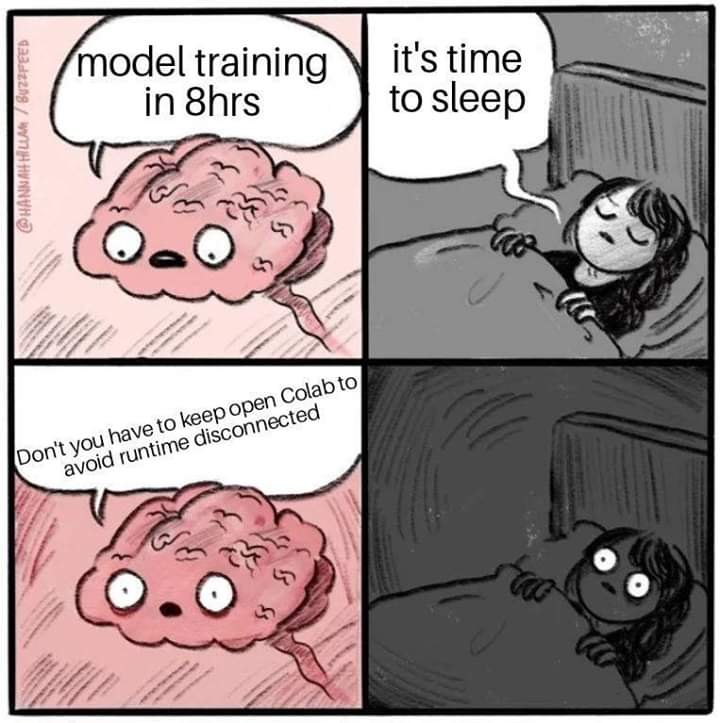

## Start a new study

In [ ]:
study = optuna.create_study(
    study_name="CartpoleOptimizations_noeps",
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=50),
    storage="sqlite:////content/drive/MyDrive/catrpole_optimisation.db",
    load_if_exists=True,
)

In [ ]:
study.optimize(objective, n_trials=5)
#joblib.dump(study, "CartpoleOptimizations.pkl")

## Statistics

In [ ]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

## Visualisations

In [ ]:
optuna.visualization.plot_optimization_history(study)

#### show best 5 trials

In [ ]:
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:5]
plotted_study = optuna.create_study()
for trial in plotted_trials:
  print(trial.value)
  plotted_study.add_trial(trial)

optuna.visualization.plot_intermediate_values(plotted_study)


In [ ]:
smp_study = optuna.create_study()
smp_study.add_trial(study.best_trial)
# smp_study.add_trial(study.trials[50])
print(smp_study)
print("  Value: ", smp_study.trials[0].value)

print("  Params: ")
for key, value in smp_study.trials[0].params.items():
    print("    {}: {}".format(key, value))

optuna.visualization.plot_intermediate_values(smp_study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study, params=["optimizer"])